# 一. 感知机(Perceptron)

感知机由Frank Roseblatt于1957年提出，是一种广为使用的线性分类模型。感知机是最简单的神经网络，只有1个神经元。感知机是对生物神经元的简单数学模拟，有与生物神经相对应的部件，如权重（突触）、偏置（阈值）及激活函数（细胞体），输出为+1或-1.
感知机是二分类线性模型，对应于输入空间中将实例划分为正负两类的分离超平面，属于判别模型。感知机学习旨在求出将训练数据进行线性划分的分离超平面。为此，基于误分类的损失函数，利用梯度下降法对损失函数进行极小化，求得感知机模型。

## 1. 模型

定义2.1 （感知机） 假设输入控件是$\mathbf{X} \subseteq \mathbf{R^n}$，输出控件是$\mathbf{Y=\{+1,-1\}}$。输入$x\in \mathbf{X}$表示实例的特征向量，对应于输入空间的点；输出$y\in \mathbf{Y}$表示实例的类别。由输入空间到输出空间的如下函数
$$
f(x)=\mathrm{sign} (\omega\cdot x+b)
$$
称为感知机。其中，$\omega$和$b$为感知机模型参数，$\omega\in\mathbf{R^n}$为权重值或者权值向量，$b\in\mathbf{R}$称为偏置。$sign$是符号函数，即
$$
\begin{equation}
\mathrm{sign}(x)=\begin{cases}
+1,x\geq 0 \\
-1,x<0
\end{cases}
\end{equation}
$$

感知机的假设空间是定义在特征空间上的所有线性分类模型或线性分类器，即函数集合$\{f|f(x)=\omega\cdot x + b\}$

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
def percetron(w, x, b):
    '''
    w: 参数向量 n, 1
    x: 矩阵 m, n
    b: 偏置，标量
    '''
    return torch.sign(x@w + b)

In [3]:
x0 = torch.randn(100, 2) + 2  # 均值为 2
y0 = torch.zeros(100)
x1 = torch.randn(100, 2) - 2  # 均值为 -2
y1 = torch.ones(100)

x = torch.cat((x0, x1)).type(torch.FloatTensor)
y = torch.cat((y0, y1)).type(torch.LongTensor)

In [6]:
idx = np.arange(len(x))
np.random.shuffle(idx)
train_x, train_y = x[idx[:50]], y[idx[:50]]  # 随机选取50个
test_x, test_y = x[idx[50:]], y[idx[50:]]

In [12]:
x_list = [train_x, test_x]
y_list = [train_y, test_y]

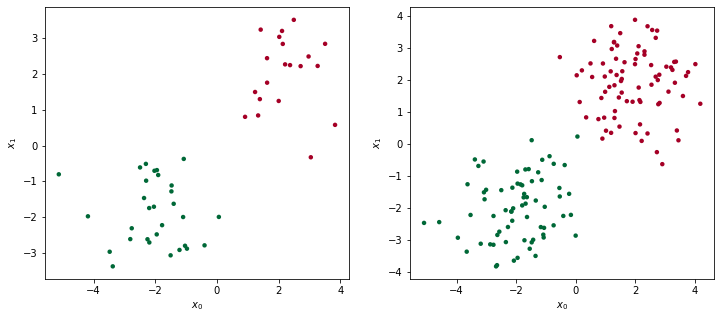

In [14]:
fig = plt.figure(figsize=(12, 5))
for i in range(2):
    px = x_list[i]
    py = y_list[i]
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.scatter(px.data.numpy()[:,0], px.data.numpy()[:,1], c=py.data.numpy(), s=20, lw=0, cmap='RdYlGn')